#Final Project for ML


## Installing dependencies

In [12]:
!pip install haversine
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install category_encoders
!pip install xgboost

In [13]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from haversine import haversine, Unit
from sklearn.datasets import fetch_california_housing
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble        import RandomForestRegressor
from category_encoders import TargetEncoder
from xgboost import XGBRegressor

## Loading dataset
### California Housing dataset
| Column       | Description                                                  | Units (approx.) |
|--------------|--------------------------------------------------------------|-----------------|
| **MedInc**   | Median income of households in the block group              | × $10 000       |
| **HouseAge** | Median age of houses in the block                            | years           |
| **AveRooms** | Average number of rooms per household                        | rooms           |
| **AveBedrms**| Average number of bedrooms per household                     | bedrooms        |
| **Population**| Total population in the block group                         | persons         |
| **AveOccup** | Average number of household members                          | persons/house   |
| **Latitude** | Centroid latitude of the block group                         | degrees N       |
| **Longitude**| Centroid longitude of the block group (negative = west)      | degrees W       |
| **MedHouseVal** | **Target** — median house value    

In [74]:
df = fetch_california_housing(as_frame=True).frame

In [44]:
print(df.shape)
print(df.info())
print(df.describe().T)

(20640, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
               count         mean          std         min         25%  \
MedInc       20640.0     3.870671     1.899822    0.499900    2.563400   
HouseAge     20640.0    28.639486    12.585558    1.000000   18.000000   
AveRooms     20640.0     5.429000     2.474173    0.846154    4.440716   
AveBedrms    20640.0     1.096675     0.473911    0.333333    1.006079   
Popu

### Checking missing values:

As we can see, we don't have any missing value here

In [16]:
print("Missing values in df (per column):")
print(df.isna().sum())

Missing values in df (per column):
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64


In [17]:
X_raw = df.drop('MedHouseVal', axis=1)
y_raw = df['MedHouseVal']

### In case of missing values(We don't have any)

In [ ]:
df['Latitude'].fillna(df['Latitude'].mean(), inplace=True)

## Plotting the columns feature relations

<Axes: >

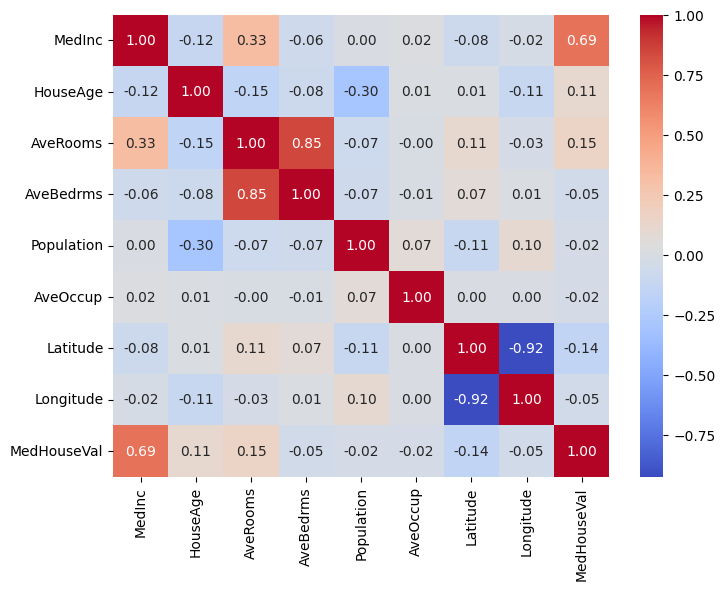

In [18]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

### Some conclusions
As we can see from the correlation plot, there is a high correlation between these features:

MedInc <---> MedHouseVal

HouseAge <---> MedHouseVal

AveRooms <---> MedHouseVal

AveRooms <---> AveBedrms

## BaseLine solution
We use linear regresion as our baseline model to compare with:

Next we will try to research features and make some feature engineering and try linear regression again to see if it helps.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw,
                                                    test_size=0.2,
                                                    random_state=42)
base_lr = LinearRegression().fit(X_train, y_train)
base_pred = base_lr.predict(X_test)
mse = mean_squared_error(y_test, base_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, base_pred)
r2 = r2_score(y_test, base_pred)
print(f"MSE   = {mse:.4f}   (lower is better)")
print(f"RMSE  = {rmse:.4f}   (lower is better)")
print(f"MAE   = {mae:.4f}   (lower is better)")
print(f"R²    = {r2:.4f}    (higher is better)")

MSE   = 0.5559   (lower is better)
RMSE  = 0.7456   (lower is better)
MAE   = 0.5332   (lower is better)
R²    = 0.5758    (higher is better)


## Feature Engineering

### Checking distribution of each feature

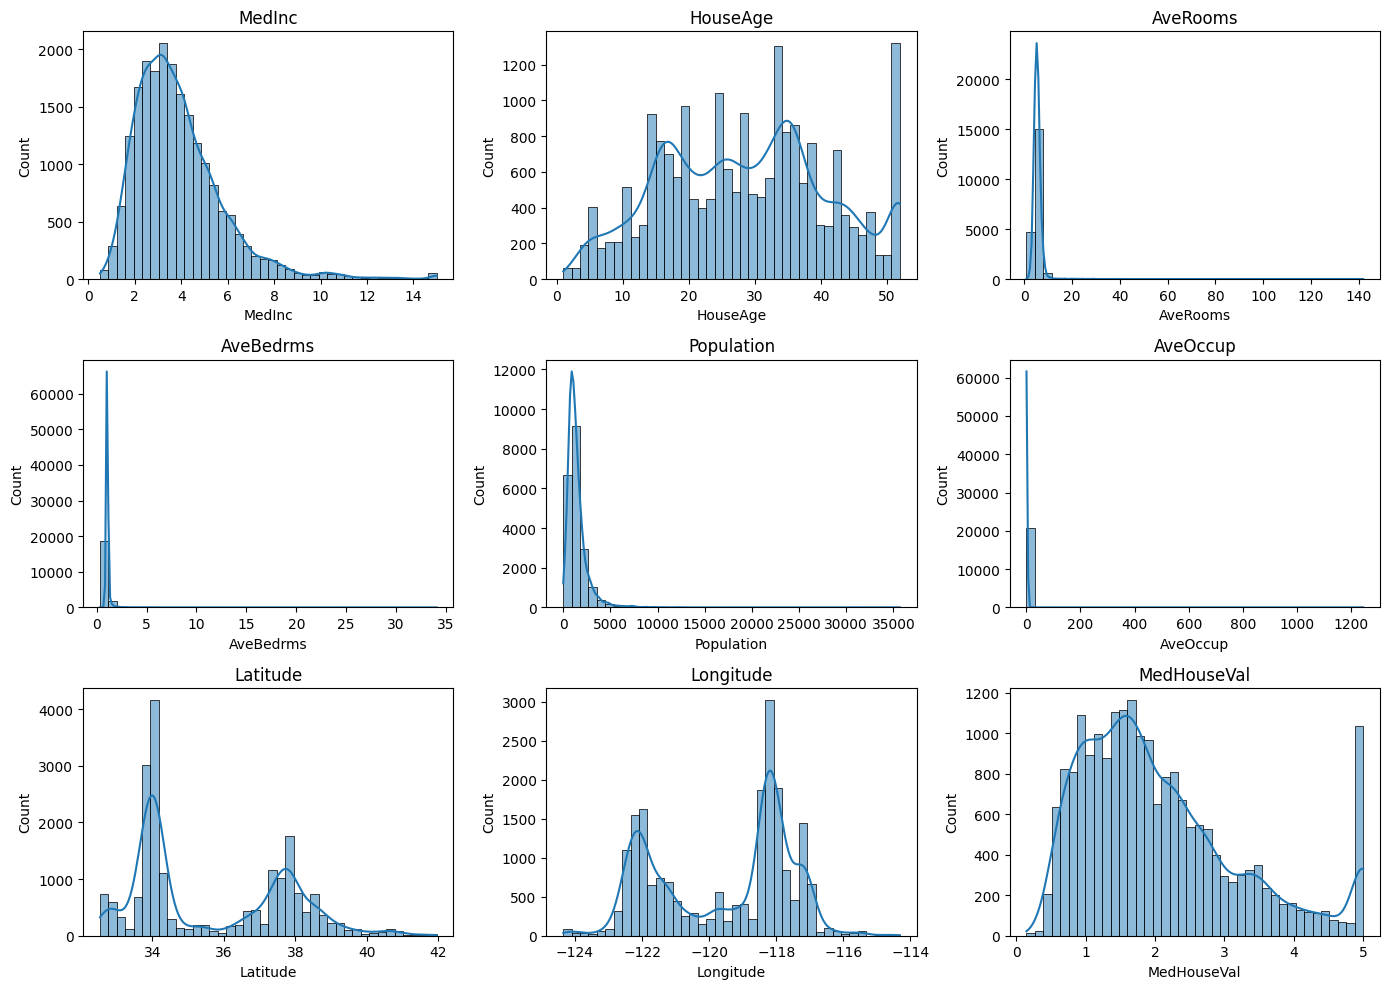

In [9]:
# Distribution of every variable
fig, axes = plt.subplots(3, 3, figsize=(14,10))
for ax, col in zip(axes.flatten(), df.columns):
    sns.histplot(df[col], bins=40, ax=ax, kde=True)
    ax.set_title(col)
fig.tight_layout()

### Checking geographic heatmap of prices

Text(0, 0.5, 'Latitude')

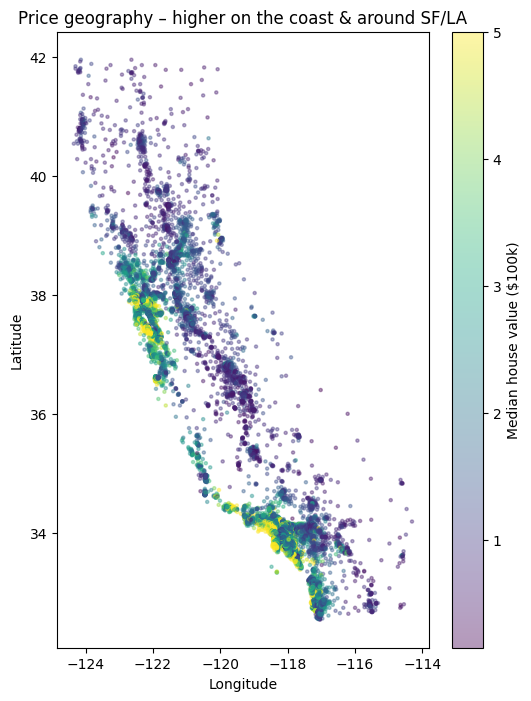

In [10]:
# Geographic heatmap of prices (Lat vs Long)
plt.figure(figsize=(6,8))
plt.scatter(df['Longitude'], df['Latitude'], c=y_raw, cmap='viridis', s=5, alpha=0.4)
plt.colorbar(label='Median house value ($100k)')
plt.title('Price geography – higher on the coast & around SF/LA')
plt.xlabel('Longitude'); plt.ylabel('Latitude')

### Division line between cheap and expensive houses

As we can see here we have some separation between cheap and expensive houses


Fitted model: ŷ = -58.2940 + -0.7121·Lon + -0.6955·Lat
Using threshold = 1.797 ($100k)


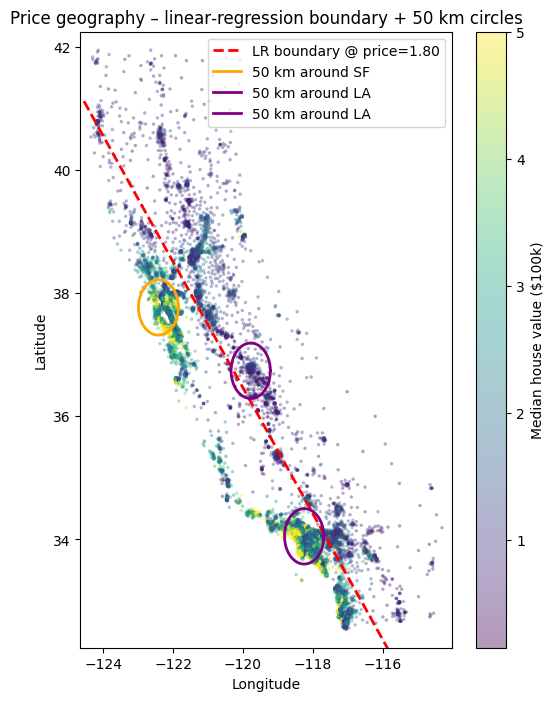

In [20]:
lon = df["Longitude"].values
lat = df["Latitude"].values
y_geo = y_raw.values  # medHouseVal

# Stack into a matrix for sklearn
X_geo = np.column_stack([lon, lat])  # shape = (n_samples, 2)

# ─── 2) Fit plain linear regression on (Lon, Lat) → MedHouseVal ─────────────
linreg = LinearRegression()
linreg.fit(X_geo, y_geo)
beta0, beta_lon, beta_lat = linreg.intercept_, *linreg.coef_
SF_COORD = (37.77, -122.42) 
LA_COORD = (34.05, -118.25)
CV_COORD = (36.74, -119.78)
print("Fitted model: ŷ = {:.4f} + {:.4f}·Lon + {:.4f}·Lat"
      .format(beta0, beta_lon, beta_lat))

# Choose the median‐price threshold
price_threshold = np.median(y_geo)
print("Using threshold =", price_threshold, "($100k)")

# Compute boundary line in (lon, lat) space:
lon_vals = np.linspace(lon.min() - 0.2, lon.max() + 0.2, 300)
lat_boundary = (price_threshold - beta0 - beta_lon * lon_vals) / beta_lat

# Prepare the circles
radius_km = 50.0

# Convert to degrees latitude:
radius_deg_lat = radius_km / 111.0

# Convert to degrees longitude at each center‐latitude
radius_deg_lon_SF = radius_km / (111.0 * np.cos(np.radians(SF_COORD[0])))
radius_deg_lon_LA = radius_km / (111.0 * np.cos(np.radians(LA_COORD[0])))
radius_deg_lon_LA = radius_km / (111.0 * np.cos(np.radians(CV_COORD[0])))

# Parametrize a circle with θ from 0 to 2π
theta = np.linspace(0, 2*np.pi, 200)

# SF circle in lat/lon:
sf_circle_lon = SF_COORD[1] + radius_deg_lon_SF * np.cos(theta)
sf_circle_lat = SF_COORD[0] + radius_deg_lat     * np.sin(theta)

# LA circle in lat/lon:
la_circle_lon = LA_COORD[1] + radius_deg_lon_LA * np.cos(theta)
la_circle_lat = LA_COORD[0] + radius_deg_lat     * np.sin(theta)

# CV circle in lat/lon:
cv_circle_lon = CV_COORD[1] + radius_deg_lon_LA * np.cos(theta)
cv_circle_lat = CV_COORD[0] + radius_deg_lat     * np.sin(theta)

# Plotting phase
plt.figure(figsize=(6, 8))

# scatter of all points
sc = plt.scatter(
    lon, lat,
    c=y_geo,
    cmap='viridis',
    s=6,
    alpha=0.4,
    linewidth=0
)
plt.colorbar(sc, label='Median house value ($100k)')

# linear‐regression “median” boundary
plt.plot(
    lon_vals, lat_boundary,
    color='red', linestyle='--', linewidth=2,
    label=f"LR boundary @ price={price_threshold:.2f}"
)

# plot the SF circle (in orange)
plt.plot(
    sf_circle_lon, sf_circle_lat,
    color='orange', linestyle='-', linewidth=2,
    label="50 km around SF"
)

# plot the LA circle (in purple)
plt.plot(
    la_circle_lon, la_circle_lat,
    color='purple', linestyle='-', linewidth=2,
    label="50 km around LA"
)

# plot the CV circle (in purple)
plt.plot(
    cv_circle_lon, cv_circle_lat,
    color='purple', linestyle='-', linewidth=2,
    label="50 km around LA"
)

plt.title('Price geography – linear‐regression boundary + 50 km circles')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper right')

plt.xlim(lon.min() - 0.3, lon.max() + 0.3)
plt.ylim(lat.min() - 0.3, lat.max() + 0.3)
plt.show()

### Key insights → feature decisions
- Income & location dominate: coastal blocks (long ≈ –124 to –118) and median‑income > 4 ($40 000) have drastically higher prices ⇒ include interactions MedInc*Latitude, MedInc*Longitude or spline‑bins.
- Non‑linear saturation: price flattens for MedInc beyond 10 → take log(MedInc) or use polynomial.
- Rooms vs Occupancy: High AveRooms but low RoomsPerHH (tiny apartments) drive price up in urban nodes ⇒ create RoomsPerHH & PopPerHH ratios.
- Latitude curvature: Price peaks around lat ~34 (LA) & 38 (SF) then falls; a simple linear term misses this ⇒ try sin/cos or polynomial of lat.

---
### Feature engineering strategy

| Idea | Code sketch | Rationale |
|------|-------------|-----------|
| **Log-scale skewed vars** (`MedInc`, `AveRooms`, `AveBedrms`, `Population`) | `np.log1p(x)` | Linearises multiplicative effects and reduces right-skew |
| **Interaction terms** | `PolynomialFeatures(degree=2, include_bias=False)` on selected vars | Captures gentle curvature without moving to a non-linear model |
| **Ratios** | `rooms_per_household = AveRooms / AveOccup` <br> `bedrooms_per_room = AveBedrms / AveRooms` | Classic housing heuristics; improve signal-to-noise |
| **Latitude × Longitude** | `lat_long = Latitude * Longitude` | Encodes geo-quadrants (north-west vs south-east, etc.) |
| **Standard scaling** | `StandardScaler()` inside the pipeline | Keeps coefficients comparable; essential for regularisation |
| **Regularisation** | `RidgeCV` or `LassoCV` | Shrinks noisy high-dimensional interactions |
| **LA, SF, CV distance** | Adding distance from `San Francisco`, `Fresno` and `Los Angeles` as new features | There is some concentration of cheap/expensive houses




In [21]:
# 5.1  Define handcrafted ratio & geo features + robust names
def add_features(df):
    """Add domain‑inspired columns and keep names consistent."""
    df = df.copy()
    # Ratios
    df['RoomsPerHH'] = df['AveRooms'] / df['AveOccup']
    df['BedsPerRoom'] = df['AveBedrms'] / (df['AveRooms'] + 1e-3)
    df['PopPerHH']   = df['Population'] / df['AveOccup']
    # Interaction of coords (quadrant encoding)
    df['LatLong']    = df['Latitude'] * df['Longitude']
    # Distance to downtown San Francisco (great‑circle, km)
    coords = list(zip(df["Latitude"], df["Longitude"]))
    df["DistSF_km"] = [
        haversine(
            (lat, lon),
            SF_COORD,
            unit=Unit.KILOMETERS
        )
        for (lat, lon) in coords
    ]

    df["DistLA_km"] = [
        haversine(
            (lat, lon),
            LA_COORD,
            unit=Unit.KILOMETERS
        )
        for (lat, lon) in coords
    ]

    df["DistCV_km"] = [
        haversine(
            (lat, lon),
            CV_COORD,
            unit=Unit.KILOMETERS
        )
        for (lat, lon) in coords
    ]
    return df

# FunctionTransformer that **adds** columns: don't set feature_names_out, we let pandas output keep names
ratio_ft = FunctionTransformer(add_features)

num_cols = X_raw.columns.tolist()  # original eight

# 5.2  Selective log1p transformer (skip longitude & LatLong, which can be negative)
log_cols = [
    'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
    'RoomsPerHH', 'BedsPerRoom', 'PopPerHH', 'DistSF_km', 'DistLA_km'
]

def safe_log1p(df):
    df = df.copy()
    cols = df.columns.intersection(log_cols)  # only log columns that exist
    df[cols] = np.log1p(df[cols])
    return df

log_ft = FunctionTransformer(safe_log1p)

numeric_pipeline = Pipeline([
    ("ratios", ratio_ft),              # add new columns & distance
    ("log",    log_ft),                # log only non-negative features
    ("scale",  StandardScaler()),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False))
]).set_output(transform="pandas")

# Single, correct ColumnTransformer
full_pre = ColumnTransformer(
    [("num", numeric_pipeline, num_cols)],
    remainder="drop"
).set_output(transform="pandas")

In [22]:
alphas = np.logspace(-3, 3, 13)
model = Pipeline([
    ("prep",  full_pre),
    ("ridge", RidgeCV(alphas=alphas, cv=5))
])
model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ratios',
                                                                   FunctionTransformer(func=<function add_features at 0x7fd21beb39c0>)),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function safe_log1p at 0x7fd21beb37e0>)),
                                                                  ('scale',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['MedInc', 'HouseAge',
                                                   'AveRooms', 'AveBedrms',
                                                   'Population', 'AveOccup',
                                                   'Latitude',
                                                   'Longitude'])])),
                ('ridge',
                 RidgeCV(alphas=array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                         cv=5))])

In [23]:
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f"MSE   = {mse:.4f}   (lower is better)")
print(f"RMSE  = {rmse:.4f}   (lower is better)")
print(f"MAE   = {mae:.4f}   (lower is better)")
print(f"R²    = {r2:.4f}    (higher is better)")

MSE   = 0.3199   (lower is better)
RMSE  = 0.5656   (lower is better)
MAE   = 0.3862   (lower is better)
R²    = 0.7559    (higher is better)


Text(0.5, 1.0, 'Predicted vs Actual - Ridge')

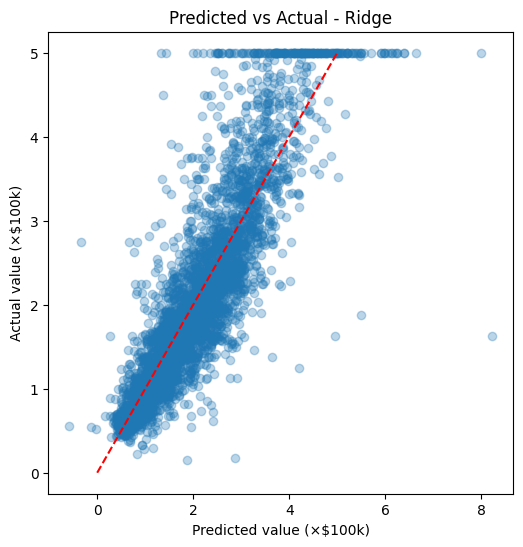

In [24]:
plt.figure(figsize=(6,6))
plt.scatter(pred, y_test, alpha=0.3)
plt.plot([0, 5], [0, 5], '--', color='r')
plt.xlabel("Predicted value (×$100k)")
plt.ylabel("Actual value (×$100k)")
plt.title("Predicted vs Actual - Ridge")

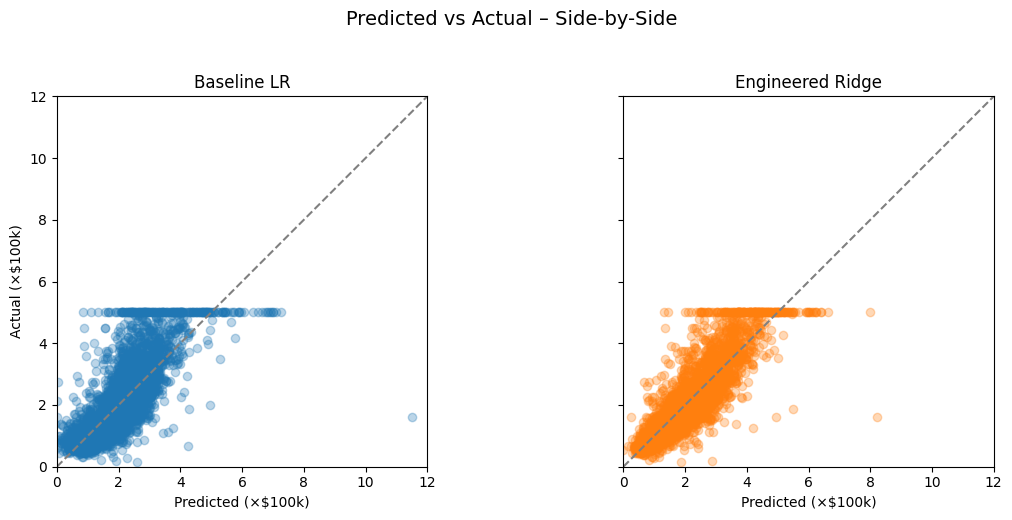

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# ── 1) Collect all values that should influence the limits ────────────────
all_pred = np.concatenate([base_pred, pred])
all_true = y_test.values     

lo = 0                              
hi = np.ceil(max(all_pred.max(), all_true.max()))  # round up to nearest int

# ── 2) Plot side-by-side with shared scaling ─────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Baseline LR
axes[0].scatter(base_pred, y_test, alpha=0.3)
axes[0].plot([lo, hi], [lo, hi], '--', color='gray')
axes[0].set_title('Baseline LR')
axes[0].set_xlabel('Predicted (×$100k)')
axes[0].set_ylabel('Actual (×$100k)')

# Engineered Ridge
axes[1].scatter(pred, y_test, alpha=0.3, color='tab:orange')
axes[1].plot([lo, hi], [lo, hi], '--', color='gray')
axes[1].set_title('Engineered Ridge')
axes[1].set_xlabel('Predicted (×$100k)')

# ── 3) Apply the common limits & equal aspect ────────────────────────────
for ax in axes:
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_aspect('equal', adjustable='box')   # keep 45° line at actual 45°

plt.suptitle('Predicted vs Actual – Side-by-Side', y=1.03, fontsize=14)
plt.tight_layout()
plt.show()

## Advanced method for regression

### Baseline Random Forest

It outperforms the feature engineered version of linear regression

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.20, random_state=42
)
rf_pipeline =RandomForestRegressor(
                 n_estimators=100,
                 max_depth=None,
                 min_samples_leaf=3,
                 random_state=42,
                 n_jobs=-1
             )
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)

mse_rf  = mean_squared_error(y_test, rf_preds)
rmse_rf = sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, rf_preds)
r2_rf   = rf_pipeline.score(X_test, y_test)

print(f"MSE   = {mse_rf:.4f}   (lower is better)")
print(f"RMSE  = {rmse_rf:.4f}   (lower is better)")
print(f"MAE   = {mae_rf:.4f}   (lower is better)")
print(f"R²    = {r2_rf:.4f}    (higher is better)")

MSE   = 0.2572   (lower is better)
RMSE  = 0.5072   (lower is better)
MAE   = 0.3281   (lower is better)
R²    = 0.8037    (higher is better)


### Using the old feature engineering method

In [29]:
alphas = np.logspace(-3, 3, 13)
model = Pipeline([
    ("prep",  full_pre),
    ("ridge", RandomForestRegressor(
                 n_estimators=100,
                 max_depth=None,
                 min_samples_leaf=3,
                 random_state=42,
                 n_jobs=-1
             ))
])
model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ratios',
                                                                   FunctionTransformer(func=<function add_features at 0x7fd21beb39c0>)),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function safe_log1p at 0x7fd21beb37e0>)),
                                                                  ('scale',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['MedInc', 'HouseAge',
                                                   'AveRooms', 'AveBedrms',
                                                   'Population', 'AveOccup',
                                                   'Latitude',
                                                   'Longitude'])])),
                ('ridge',
                 RandomForestRegressor(min_samples_leaf=3, n_jobs=-1,
                                       random_state=42))])

In [30]:
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f"MSE   = {mse:.4f}   (lower is better)")
print(f"RMSE  = {rmse:.4f}   (lower is better)")
print(f"MAE   = {mae:.4f}   (lower is better)")
print(f"R²    = {r2:.4f}    (higher is better)")

MSE   = 0.2244   (lower is better)
RMSE  = 0.4737   (lower is better)
MAE   = 0.3065   (lower is better)
R²    = 0.8288    (higher is better)


In [45]:
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')

## XGB with hyperparameter tuning

#### Without feature engineering

In [75]:
# split into train/test
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"].clip(upper=df["MedHouseVal"].quantile(0.995))   # mild clipping
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=.2, random_state=42)

# preprocess
num_cols = X_tr.select_dtypes(exclude="category").columns
pre = ColumnTransformer([
    ("num", Pipeline([("sc", StandardScaler())]), num_cols),
])

# setup xgboost
xgb = XGBRegressor(tree_method="hist", eval_metric="rmse", n_jobs=-1, random_state=42)
param = {
    "xgb__n_estimators":[600,800,1000],
    "xgb__max_depth":[6,8],
    "xgb__learning_rate":[0.03,0.05],
    "xgb__subsample":[0.7,0.9],
    "xgb__colsample_bytree":[0.6,0.8]
}
pipe = Pipeline([("pre", pre), ("xgb", xgb)])
search = RandomizedSearchCV(pipe, param, n_iter=20,
                            scoring="neg_root_mean_squared_error",
                            cv=5, n_jobs=-1, random_state=42)
search.fit(X_tr, y_tr)
pred = search.predict(X_te)
mse = mean_squared_error(y_test, pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f"MSE   = {mse:.4f}   (lower is better)")
print(f"RMSE  = {rmse:.4f}   (lower is better)")
print(f"MAE   = {mae:.4f}   (lower is better)")
print(f"R²    = {r2:.4f}    (higher is better)")

MSE   = 0.1884   (lower is better)
RMSE  = 0.4341   (lower is better)
MAE   = 0.2799   (lower is better)
R²    = 0.8562    (higher is better)


#### Adding distances from SF, LA, CV

In [76]:
# Adding LA, SF distances
df["DistSF_km"] = [haversine((lt,ln), SF_COORD, unit=Unit.KILOMETERS) for lt,ln in zip(df.Latitude, df.Longitude)]
df["DistLA_km"] = [haversine((lt,ln), LA_COORD, unit=Unit.KILOMETERS) for lt,ln in zip(df.Latitude, df.Longitude)]
df["DistCV_km"] = [haversine((lt,ln), CV_COORD, unit=Unit.KILOMETERS) for lt,ln in zip(df.Latitude, df.Longitude)]

# perform region clustering
from sklearn.cluster import KMeans
df["RegionID"] = KMeans(n_clusters=5, random_state=42).fit_predict(df[["Latitude","Longitude"]]).astype(str)

# split into train/test
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"].clip(upper=df["MedHouseVal"].quantile(0.995))   # mild clipping
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=.2, random_state=42)

# preprocess
num_cols = X_tr.select_dtypes(exclude="category").columns
cat_cols = ["RegionID"]
pre = ColumnTransformer([
    ("num", Pipeline([("sc", StandardScaler())]), num_cols),
    ("cat", TargetEncoder(), cat_cols)
])

# setup xgboost
xgb = XGBRegressor(tree_method="hist", eval_metric="rmse", n_jobs=-1, random_state=42)
param = {
    "xgb__n_estimators":[600,800,1000],
    "xgb__max_depth":[6,8],
    "xgb__learning_rate":[0.03,0.05],
    "xgb__subsample":[0.7,0.9],
    "xgb__colsample_bytree":[0.6,0.8]
}
pipe = Pipeline([("pre", pre), ("xgb", xgb)])
search = RandomizedSearchCV(pipe, param, n_iter=20,
                            scoring="neg_root_mean_squared_error",
                            cv=5, n_jobs=-1, random_state=42)
search.fit(X_tr, y_tr)
pred = search.predict(X_te)
mse = mean_squared_error(y_test, pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f"MSE   = {mse:.4f}   (lower is better)")
print(f"RMSE  = {rmse:.4f}   (lower is better)")
print(f"MAE   = {mae:.4f}   (lower is better)")
print(f"R²    = {r2:.4f}    (higher is better)")

MSE   = 0.1777   (lower is better)
RMSE  = 0.4215   (lower is better)
MAE   = 0.2699   (lower is better)
R²    = 0.8644    (higher is better)


#### Adding clusters instead of SF, LA, CV and RegionID + Hyperparameter tuning

In [77]:
cal = fetch_california_housing(as_frame=True)
df  = cal.frame.copy()

kmeans = KMeans(n_clusters=10, random_state=42)
regions = kmeans.fit_predict(df[["Latitude", "Longitude"]])
df["RegionID"] = regions.astype(str)

cluster_centers = kmeans.cluster_centers_  # shape = (10, 2)

for i, (cent_lat, cent_lon) in enumerate(cluster_centers):
    df[f"DistCentroid{i}_km"] = [
        haversine((lat, lon), (cent_lat, cent_lon), unit=Unit.KILOMETERS)
        for lat, lon in zip(df["Latitude"], df["Longitude"])
    ]

X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"].clip(upper=df["MedHouseVal"].quantile(0.995))

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_cols = X_tr.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = ["RegionID"]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", TargetEncoder(), cat_cols)
], remainder="drop")

xgb = XGBRegressor(
    tree_method="hist",
    eval_metric="rmse",
    random_state=42,
    n_jobs=-1
)
param_distributions = {
    "xgb__n_estimators":     [600, 800, 1000],
    "xgb__max_depth":        [6, 8],
    "xgb__learning_rate":    [0.03, 0.05],
    "xgb__subsample":        [0.7, 0.9],
    "xgb__colsample_bytree": [0.6, 0.8]
}

pipeline = Pipeline([
    ("pre", preprocessor),
    ("xgb", xgb)
])

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
search.fit(X_tr, y_tr)

pred = search.predict(X_te)
mse_val  = mean_squared_error(y_te, pred)
rmse_val = sqrt(mse_val)
mae_val  = mean_absolute_error(y_te, pred)
r2_val   = r2_score(y_te, pred)

print(f"MSE   = {mse_val:.4f}   (lower is better)")
print(f"RMSE  = {rmse_val:.4f}   (lower is better)")
print(f"MAE   = {mae_val:.4f}   (lower is better)")
print(f"R²    = {r2_val:.4f}    (higher is better)")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
MSE   = 0.1709   (lower is better)
RMSE  = 0.4134   (lower is better)
MAE   = 0.2627   (lower is better)
R²    = 0.8696    (higher is better)


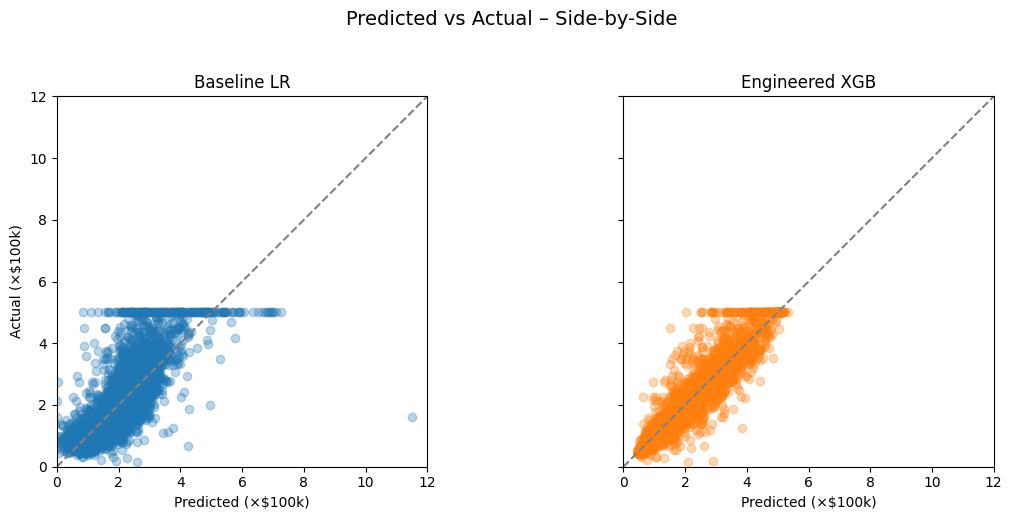

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# ── 1) Collect all values that should influence the limits ────────────────
all_pred = np.concatenate([base_pred, pred])
all_true = y_test.values     

lo = 0                              
hi = np.ceil(max(all_pred.max(), all_true.max()))  # round up to nearest int

# ── 2) Plot side-by-side with shared scaling ─────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Baseline LR
axes[0].scatter(base_pred, y_test, alpha=0.3)
axes[0].plot([lo, hi], [lo, hi], '--', color='gray')
axes[0].set_title('Baseline LR')
axes[0].set_xlabel('Predicted (×$100k)')
axes[0].set_ylabel('Actual (×$100k)')

# Engineered Ridge
axes[1].scatter(pred, y_test, alpha=0.3, color='tab:orange')
axes[1].plot([lo, hi], [lo, hi], '--', color='gray')
axes[1].set_title('Engineered XGB')
axes[1].set_xlabel('Predicted (×$100k)')

# ── 3) Apply the common limits & equal aspect ────────────────────────────
for ax in axes:
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_aspect('equal', adjustable='box')   # keep 45° line at actual 45°

plt.suptitle('Predicted vs Actual – Side-by-Side', y=1.03, fontsize=14)
plt.tight_layout()
plt.show()

# Model Performance Comparison

Below are the key regression metrics for two models: a **Baseline Linear Regression (LR)** and an **Advanced (Engineered) XGB**. All metrics are computed on the same test set (Median House Value in \$100 k units).

---

## 1. Baseline Linear Regression

- **MSE**   = 0.5559   (lower is better)  
- **RMSE**  = 0.7456   (lower is better)  
- **MAE**   = 0.5332   (lower is better)  
- **R²**    = 0.5758   (higher is better)  

---

## 2. Advanced (Engineered) XGB

- **MSE**   = 0.1709   (lower is better)  
- **RMSE**  = 0.4134   (lower is better)  
- **MAE**   = 0.2627   (lower is better)  
- **R²**    = 0.8696   (higher is better)  

---

## Summary

- The **Baseline LR** explains about 57.6 % of the variance (R² = 0.5758), with an RMSE of 0.7456 (\$74.56 k).  
- The **Advanced XGB** explains about 87 % of the variance (R² = 0.8696), with a much lower RMSE of 0.4134 (\$41.34 k).  

Since **lower MSE/RMSE/MAE** and **higher R²** are better, the engineered Ridge model is substantially more accurate than the baseline Linear Regression.